Finding the boundary using morphalogical geodesic active contour
======================================================


Using Active contour model suggested in https://scikit-image.org/docs/dev/auto_examples/edges/plot_active_contours.html 
https://reader.elsevier.com/reader/sd/pii/S0262885600000925?token=3FB5392838846C6CD718F9BDDE2610C5367CB05D4F52521B4900C91A49BD1B56A908F1851D9AEBC003FFB6CF2EB4CF41
https://www.sciencedirect.com/science/article/pii/S0262885600000925

will see how this works for the binary maps created using the segmentations, and then move to the more complex liver boundary

image(N, M) or (N, M, 3) ndarray
Input image.

snake(N, 2) ndarray
Initial snake coordinates. For periodic boundary conditions, endpoints must not be duplicated.

alphafloat, optional
Snake length shape parameter. Higher values makes snake contract faster.

betafloat, optional
Snake smoothness shape parameter. Higher values makes snake smoother.

w_linefloat, optional
Controls attraction to brightness. Use negative values to attract toward dark regions.

w_edgefloat, optional
Controls attraction to edges. Use negative values to repel snake from edges.

gammafloat, optional
Explicit time stepping parameter.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pylab
from scipy.spatial import distance
from skimage.color import rgb2gray
from skimage.filters import gaussian, laplace
from skimage import data, img_as_float
from skimage import filters
from skimage import measure
from skimage.segmentation import active_contour
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  circle_level_set)


def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store


#needs to be in gray?
img = data.astronaut()
img = rgb2gray(img)

#linespace returns evenly spaced numbers over a specified interval.
s = np.linspace(0, 2*np.pi, 400)

r = 250+ 100*np.sin(s)
c = 250+ 100*np.cos(s)
init = np.array([r, c]).T

snake = active_contour(gaussian(img, 3),
                       init, alpha=0.015, beta=10, gamma=0.001,
                       coordinates='rc')

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])

plt.show()

In [17]:
os.getcwd()

'/Users/gabrielbattcock/Documents/University/FourthYear/Mphys/Segmentations'

In [18]:
class ct_and_mask:
    def __init__(self,CT_file,mask_file):
        self.CT_file=np.load(CT_file)
        self.mask_file=np.load(mask_file)
        
    def snake_seg(self):
        img=self.mask_file
        s = np.linspace(0, 2*np.pi, 400)

        r = 250+ 200*np.sin(s)
        c = 150+ 200*np.cos(s)
        init = np.array([r, c]).T


        snake = active_contour(gaussian(img, 3),
                               init, alpha=0.015, beta=.2, gamma=0.001,
                               coordinates='rc')
        """w_edge=-1"""

        #fig, ax = plt.subplots(figsize=(7, 7))
        #plt.figure(figsize=(15,15))
        #ax.imshow(img, cmap=plt.cm.gray)
        #ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
        #ax.plot(snake[:, 1], snake[:, 0], '-b', lw=1)
        #ax.set_xticks([]), ax.set_yticks([])
        #ax.axis([0, img.shape[1], img.shape[0], 0])
        plt.show()
        return snake
        
        
    def snake_CT(self):
        img=self.CT_file
        #s = np.linspace(0, 2*np.pi, 400)
      
        """
        look into using the snake defined by the segmentation as the line use to base this snake off of
        
        try LAPLACE filter on this SCIimage laplacian for maximum
        
        
        """
        contour=self.snake_seg()
        
        #r = contour(0,150,100)
        #c = contour(0,150,100)
        init = contour
        laplace_img=laplace(img)
        gaussian_img=gaussian(laplace_img)

        snake = active_contour(laplace_img, init,
                               alpha=0.015,w_line=.5, beta=.0001, gamma=0.001)
                                

        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(img, cmap=plt.cm.gray)
        ax.plot(init[:, 1], init[:, 0], '--r', lw=0.5)
        ax.plot(snake[:, 1], snake[:, 0], '-b', lw=1)
        ax.set_xticks([]), ax.set_yticks([])
        ax.axis([0, img.shape[1], img.shape[0], 0])

        plt.show()
        #return snake
    
    def remove_background(self):
        pixel_array = self.CT_file

        threshold_value = filters.threshold_otsu(pixel_array)
        # Find threshold value for separating foreground and background using Otsu thresholding

        threshold_array = np.full(pixel_array.shape, threshold_value)
        bool_array = np.greater(pixel_array, threshold_array)
        # Create boolean array of pixel array values compared to threshold value to display binary image
        # of foreground and background

        labels = measure.label(bool_array,background=1)
        # Label each connected component of binary image and create new label array

        counts = np.bincount(labels.flatten())  
        # Count number of occurences of each label in label array

        background_label = np.argmax(counts)
        # Identify the label number of the background as the bin containing the greatest number

        pixel_array_normalized = (pixel_array - np.min(pixel_array))/(np.max(pixel_array)-np.min(pixel_array))
        # Normalize pixel array between 0 and 1

        normalized_threshold_value = filters.threshold_otsu(pixel_array_normalized)
        
        flat_labels = labels.flatten()
        flat_pixel_array_normalized = pixel_array_normalized.flatten()
        
        final_array=np.zeros(pixel_array_normalized.shape)
        pixel_array_flat=pixel_array.flatten()
        for i in range(pixel_array.shape[0]):
            for j in range(pixel_array.shape[1]):
                if pixel_array[i,j]<threshold_value:
                    final_array[i,j]=np.NaN
                elif pixel_array[i,j]>=threshold_value:
                    final_array[i,j]=pixel_array[i,j]
        """
        for i in pixel_array_flat:
            if i<threshold_value:
                final_array[i]=np.NaN
            elif i>=threshold_value:
                final_array[i]=pixel_array_flat[i]
        
        final_array[pixel_array_flat<threshold_value]=np.NaN
        final_array[pixel_array_flat>=threshold_value]=pixel_array_flat
        """
       # flat_pixel_array_normalized_minus_background = flat_pixel_array_normalized[flat_labels != background_label]
        final_array=np.reshape(final_array,(512,512))
        
        
        return final_array
    
    def morph_GAC(self):
    # Morphological GAC
        def store_evolution_in(lst):
            """Returns a callback function to store the evolution of the level sets in
            the given list.
            """

            def _store(x):
                lst.append(np.copy(x))

            return _store
        image = self.remove_background()
        gimage = inverse_gaussian_gradient(image,alpha=200)#this preprocesses the image so that boundaries are clearer
        # Initial level set
        initial=self.snake_seg()
        #here we need to use a thresholding value to remove the background of the image by setting the values for NaN.
        
        
        
        
        normalized=(image - np.nanmin(image))/(np.nanmax(image)-np.nanmin(image))
        
        thrs_hld=np.nanpercentile(normalized,4)
        #print(thrs_hld)
        #thrsh_hold=histogram[40]#40th percentile is what is recommended in literature
        init_ls = circle_level_set(image.shape,center=(250,200),radius=20)
        # List with intermediate results for plotting the evolution
        evolution = []
        callback = store_evolution_in(evolution)
        ls = morphological_geodesic_active_contour(gimage, 200, init_ls,
                                                   smoothing=1, balloon=1,
                                                   threshold=.035,#thrs_hld,#threshold LOOKS good at .035 for some reason
                                                   iter_callback=callback)
        """
        s = np.linspace(0, 2*np.pi, 400)

        r = 250+ 200*np.sin(s)
        c = 150+ 200*np.cos(s)
        init = np.array([r, c]).T
        snake = active_contour(ls, init, alpha=0.015, beta=.1, gamma=0.001,
                               coordinates='rc')
        
        http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.307.3979&rep=rep1&type=pdf
        morphological_geodesic_active_contour(gimage, 50, init_ls,
                                                   smoothing=1, balloon=0.25,
                                                   threshold=0.5,#threshold
                                                   iter_callback=callback)
        morphological_chan_vese(image, 35, init_level_set=init_ls, smoothing=1,
                             iter_callback=callback)
        
        fig, axes = plt.subplots(2, 1, figsize=(12, 12))
        ax = axes.flatten()
        
        ax[0].imshow(image, cmap="gray")
        ax[0].set_axis_off()
        ax[0].contour(ls, [0.5], colors='r')
        ax[0].set_title("Morphological GAC segmentation", fontsize=12)
        
        ax[1].imshow(ls, cmap="gray")
        ax[1].set_axis_off()
        ax.plot(initial[:, 1], initial[:, 0], '--r', lw=0.5)
        ax.plot(ls[:, 1], ls[:, 0], '-b', lw=1)
        contour = ax[1].contour(evolution[0], [0.5], colors='g')
        contour.collections[0].set_label("Iteration 0")
        contour = ax[1].contour(evolution[5], [0.5], colors='y')
        contour.collections[0].set_label("Iteration 100")
        contour = ax[1].contour(evolution[-1], [0.5], colors='r')
        contour.collections[0].set_label("Iteration 230")
        ax[1].legend(loc="upper right")
        title = "Morphological GAC evolution"
        ax[1].set_title(title, fontsize=12)

        fig.tight_layout()
        plt.show()
        """
        
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(image, cmap=plt.cm.gray)
        #ax = axes.flatten()

        ax.imshow(image, cmap="gray")
        ax.set_axis_off()
        ax.contour(ls, [0.5], colors='r')
        ax.plot(initial[:, 1], initial[:, 0], '-b', lw=.5)
        ax.set_xticks([]), ax.set_yticks([])
        ax.axis([0, image.shape[1], image.shape[0], 0])
        
        plt.show()
        
        return ls
        
    #def LSNScore(self):
        
    
        """
        calculates the mean pixel/measurement displacement away from liver 'boundary' 
        also gives length of liver which is measured
        
        want to take a measurement of pixel displacement ONCE blue boundary 'close' to red...
        a bit arbitrary
        
        
        """

In [19]:
def plot_boundary(snake,img_file):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(img_file, cmap=plt.cm.gray)
    #ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
    ax.plot(snake[:, 1], snake[:, 0], '-b', lw=1)
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis([0, img_file.shape[1], img_file.shape[0], 0])

    
    
    plt.show()

In [20]:
def import_LUNG(LUNG_number):
    LUNG=ct_and_mask(LUNG_number+"CTScan.npy",LUNG_number+"Segmentation.npy")
    #plot_boundary(LUNG.mask_file,LUNG.CT_file)
    plot_boundary(LUNG.snake_seg(),LUNG.mask_file)
    """
    init=LUNG.snake_seg()
    snake=LUNG.morph_GAC()
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.figure(figsize=(15,15))
    ax.imshow(LUNG.CT_file, cmap=plt.cm.gray)
    ax.plot(init[:, 1], init[:, 0], '--r', lw=.5)
    ax.plot(snake[:, 1], snake[:, 0], '-b', lw=.5)
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis([0, LUNG.CT_file.shape[1], LUNG.CT_file.shape[0], 0])
    
    plt.show()
    """
    LUNG.morph_GAC()


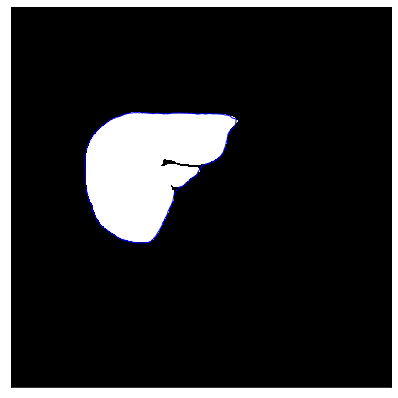

/Users/gabrielbattcock/opt/anaconda3/lib/python3.7/site-packages/skimage/segmentation/morphsnakes.py:410: RuntimeWarning: invalid value encountered in greater
  threshold_mask_balloon = image > threshold / np.abs(balloon)
/Users/gabrielbattcock/opt/anaconda3/lib/python3.7/site-packages/skimage/segmentation/morphsnakes.py:431: RuntimeWarning: invalid value encountered in greater
  u[aux > 0] = 1
/Users/gabrielbattcock/opt/anaconda3/lib/python3.7/site-packages/skimage/segmentation/morphsnakes.py:432: RuntimeWarning: invalid value encountered in less
  u[aux < 0] = 0


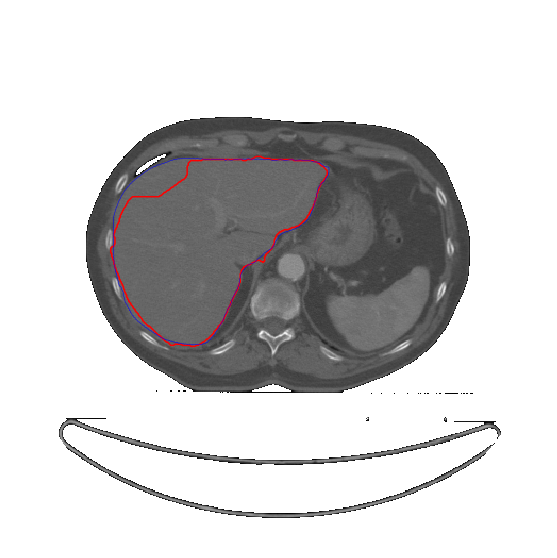

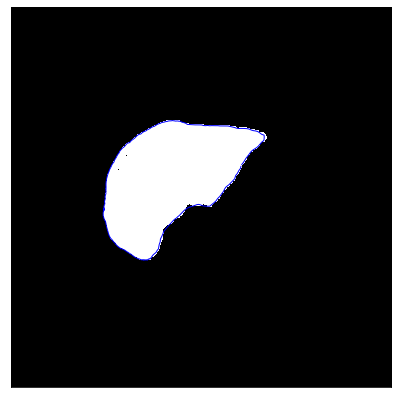

/Users/gabrielbattcock/opt/anaconda3/lib/python3.7/site-packages/skimage/segmentation/morphsnakes.py:410: RuntimeWarning: invalid value encountered in greater
  threshold_mask_balloon = image > threshold / np.abs(balloon)
/Users/gabrielbattcock/opt/anaconda3/lib/python3.7/site-packages/skimage/segmentation/morphsnakes.py:431: RuntimeWarning: invalid value encountered in greater
  u[aux > 0] = 1
/Users/gabrielbattcock/opt/anaconda3/lib/python3.7/site-packages/skimage/segmentation/morphsnakes.py:432: RuntimeWarning: invalid value encountered in less
  u[aux < 0] = 0


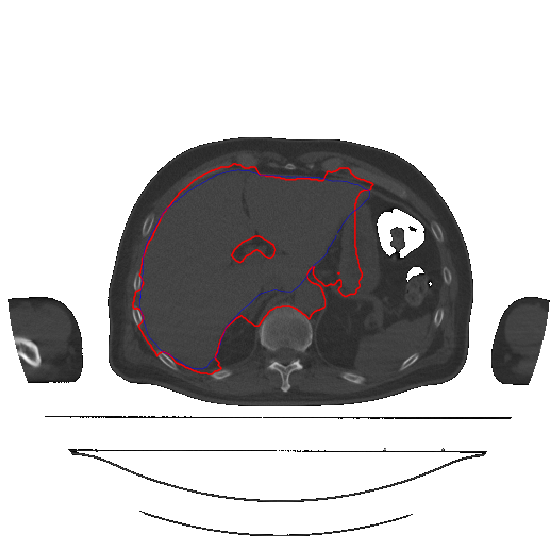

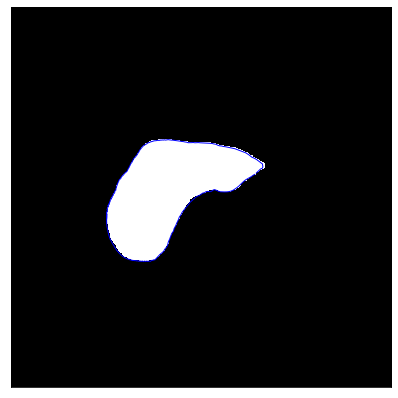

/Users/gabrielbattcock/opt/anaconda3/lib/python3.7/site-packages/skimage/segmentation/morphsnakes.py:410: RuntimeWarning: invalid value encountered in greater
  threshold_mask_balloon = image > threshold / np.abs(balloon)
/Users/gabrielbattcock/opt/anaconda3/lib/python3.7/site-packages/skimage/segmentation/morphsnakes.py:431: RuntimeWarning: invalid value encountered in greater
  u[aux > 0] = 1
/Users/gabrielbattcock/opt/anaconda3/lib/python3.7/site-packages/skimage/segmentation/morphsnakes.py:432: RuntimeWarning: invalid value encountered in less
  u[aux < 0] = 0


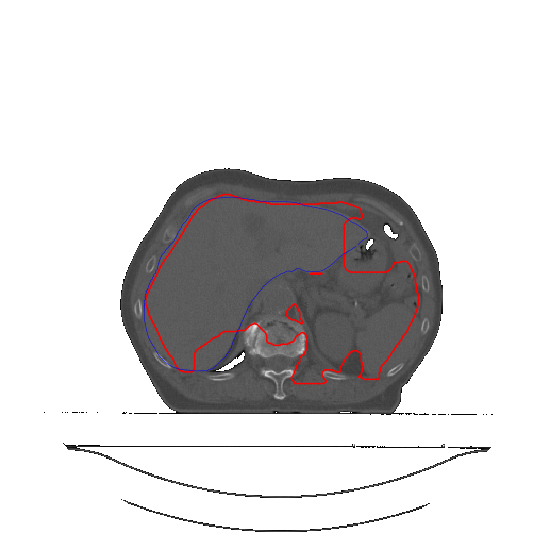

In [21]:
import_LUNG('LUNG043')
import_LUNG('LUNG50')
import_LUNG('LUNG041')


Calculating the LSN
===========================================

So for the next part of this, I want to measure the LSN, which is basically how far away the blue line is from the red line,.
I think i will have to do some sort of loop that says, if blue line is x away from red, ignore, else, calculate the LSN (create a fucntion in the class.)

In [22]:
def LSN(LUNG_number):
    LUNG=ct_and_mask(LUNG_number+"CTScan.npy",LUNG_number+"Segmentation.npy")
    snake=LUNG.morph_GAC()
    snake.shape
    coords=[[0,0],[0,0]]

    for i in range(snake.shape[0]):
        for j in range(snake.shape[1]):
            if snake[i,j]!=0:
                #print('1')
                a=np.array([[i,j]])
                coords=np.concatenate((coords,a), axis=0)
                #print(coords)
            else:
                continue
    coords=coords[1:]           
    coords.shape
    LSN=distance.cdist(LUNG049.snake_seg(),coords , 'euclidean')
    #LSN=LSN[:,0]
    for i in range(LSN.shape[0]):
        for k in range(LSN.shape[1]):
            if LSN[i,k]>3:
                continue
            else:

                a=[LSN[i,k]]
                value=np.concatenate((value,a), axis=0)
    return np.mean(value)

/Users/gabrielbattcock/opt/anaconda3/lib/python3.7/site-packages/skimage/segmentation/morphsnakes.py:410: RuntimeWarning: invalid value encountered in greater
  threshold_mask_balloon = image > threshold / np.abs(balloon)
/Users/gabrielbattcock/opt/anaconda3/lib/python3.7/site-packages/skimage/segmentation/morphsnakes.py:431: RuntimeWarning: invalid value encountered in greater
  u[aux > 0] = 1
/Users/gabrielbattcock/opt/anaconda3/lib/python3.7/site-packages/skimage/segmentation/morphsnakes.py:432: RuntimeWarning: invalid value encountered in less
  u[aux < 0] = 0


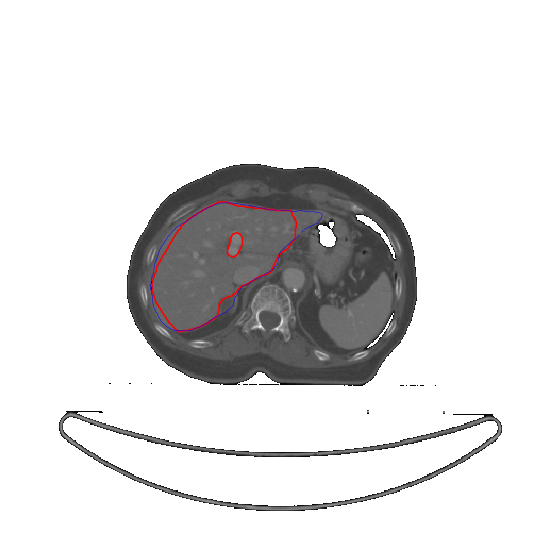

In [23]:
LUNG049=ct_and_mask("LUNG048CTScan.npy","LUNG048Segmentation.npy")
morph=LUNG049.morph_GAC()



In [24]:
"""
HERE WE WILL FIND TO LEFT AND RIGHT COORDINATES
"""
coords=[[0,0],[0,0]]

for i in range(morph.shape[0]):
    for j in range(morph.shape[1]):
        if morph[i,j]!=0:
            #print('1')
            
            a=np.array([[i,j]])
            coords=np.concatenate((coords,a), axis=0)
            #print(coords)
        else:
            continue
coords=coords[1:] 

for i in range(coords.shape[0]):
    print(np.min(coords[i,:]))
    
print(top_corner)


0
184
184
184
184
184
184
184
184
184
185
185
185
185
185
185
185
185
185
185
185
185
185
185
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
187
188
189
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
185
186
187
188
189
190
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
19

211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213


223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
240
240
240
240
240
240
240
240
240
240
240
240
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
241
241
241
241
241
241
241
241
241
241
241
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
242
242
242
242
242
242
242
242
242
142


183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178


NameError: name 'top_corner' is not defined

In [26]:
def segment_measuring(image):
    img=image
    r = np.linspace(183, 190, 100)
    c = np.linspace(200, 270, 100)
    init = np.array([r, c]).T


    snake = active_contour(gaussian(img, 3), init, boundary_condition='fixed',
                           alpha=0.015, beta=0.1, gamma=0.001,
                           coordinates='rc')

                        
    fig, ax = plt.subplots(figsize=(20, 20))
    plt.figure(figsize=(15,15))
    ax.imshow(img, cmap=plt.cm.gray)
    ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
    ax.plot(snake[:, 1], snake[:, 0], '-b', lw=1)
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis([0, img.shape[1], img.shape[0], 0])
    plt.show()
    return snake

In [27]:
def morph_measuring(image):
    img=image
    r = np.linspace(183, 190, 100)
    c = np.linspace(200, 270, 100)
    init = np.array([r, c]).T


    snake = active_contour(gaussian(img, 1), init, boundary_condition='fixed',
                           alpha=0.0015, beta=0.0001, w_line=0, w_edge=.1, gamma=0.0001,
                           coordinates='rc')

    fig, ax = plt.subplots(figsize=(20, 20))
    plt.figure(figsize=(15,15))
    ax.imshow(img, cmap=plt.cm.gray)
    ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
    ax.plot(snake[:, 1], snake[:, 0], '-b', lw=1)
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis([0, img.shape[1], img.shape[0], 0])
    plt.show()
    return snake

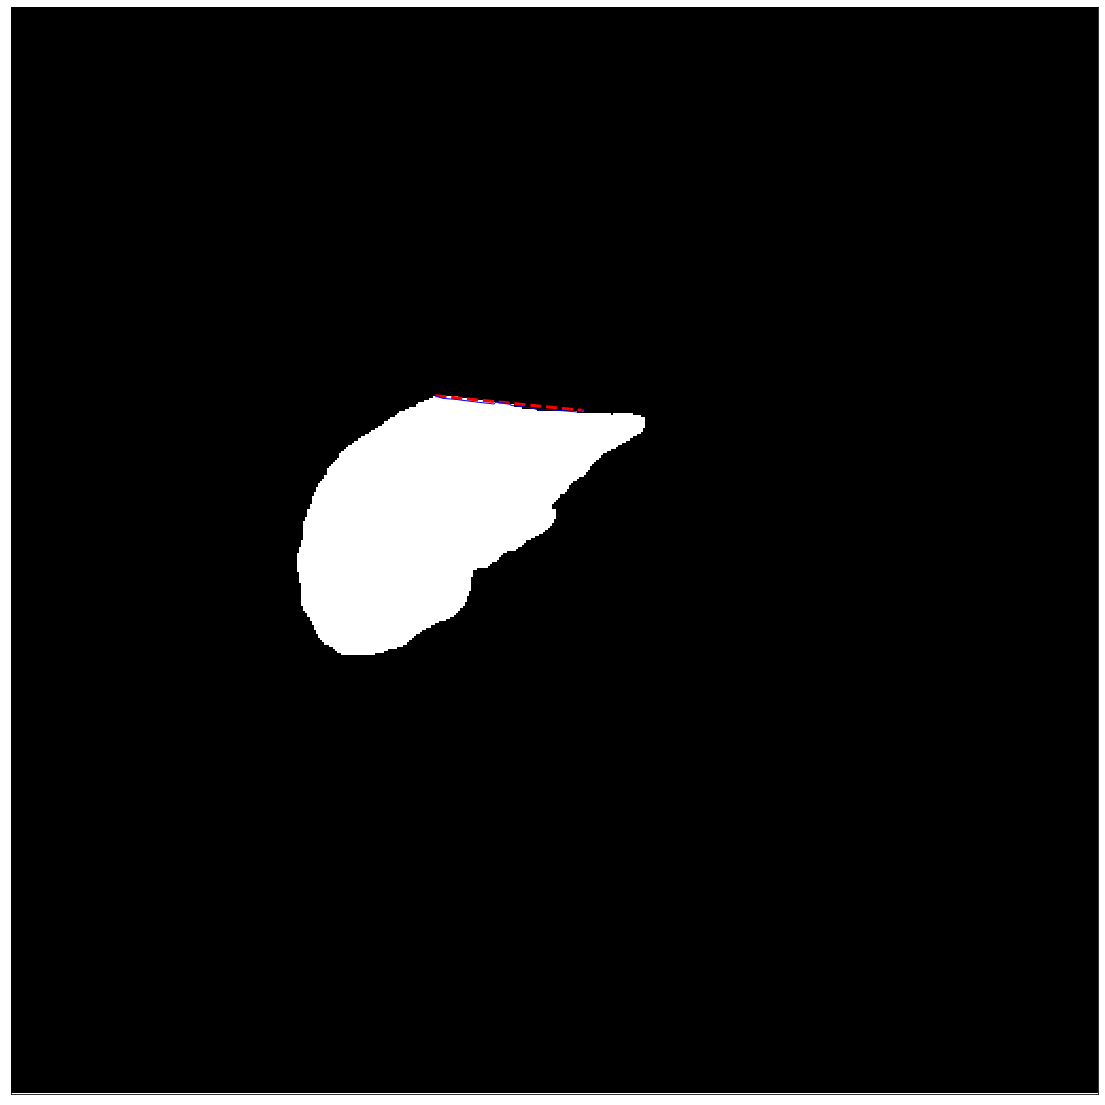

<Figure size 1080x1080 with 0 Axes>

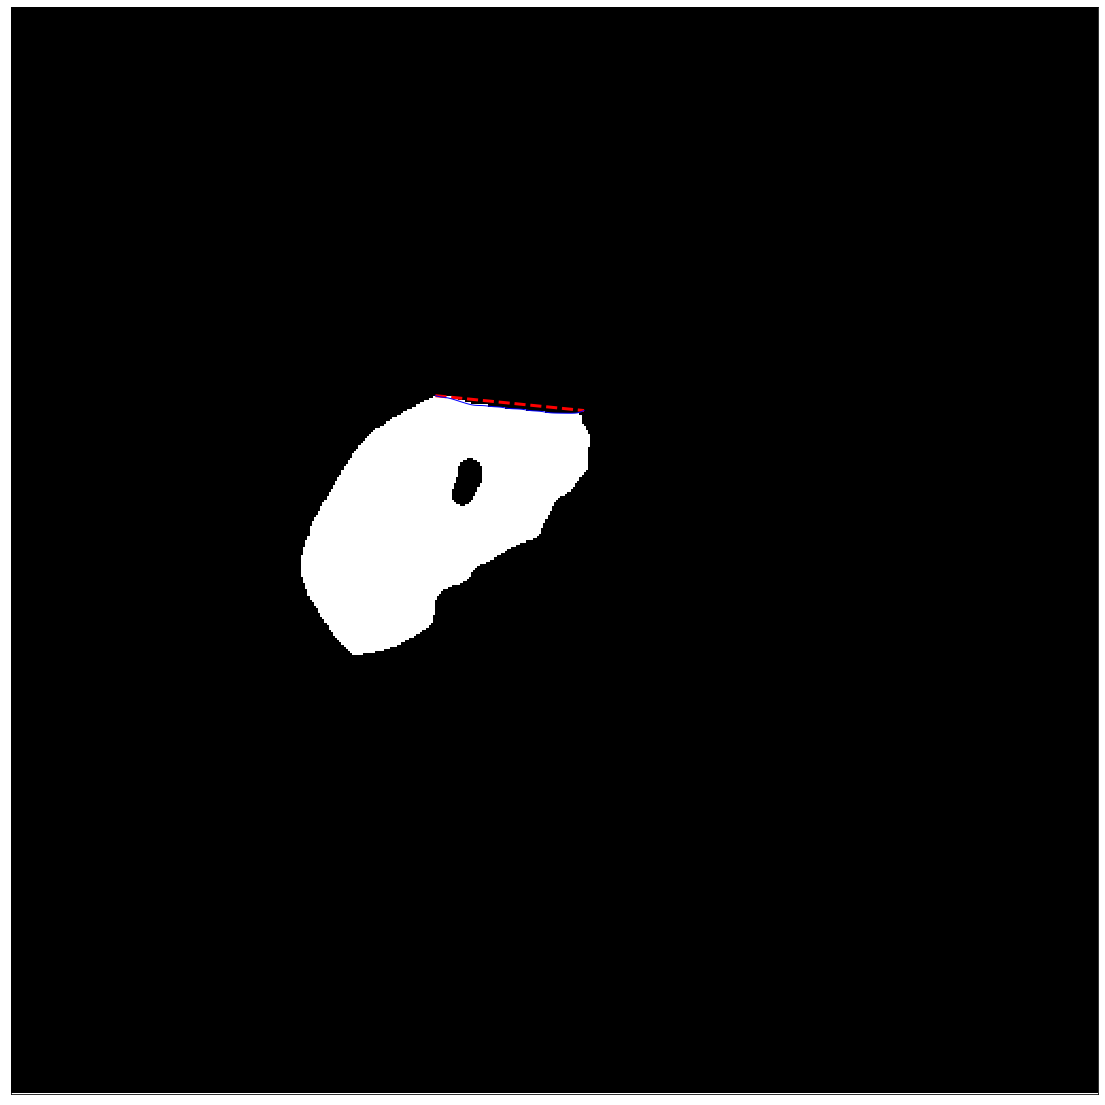

<Figure size 1080x1080 with 0 Axes>

[0.         0.24145715 0.56352482 0.89449124 1.07795231 1.21230077
 1.3266804  1.42856532 1.5187675  1.59520375 1.65917992 1.70988274
 1.74383938 1.75499136 1.74240152 1.7095021  1.66252427 1.61160325
 1.56623807 1.53476697 1.51741429 1.51542256 1.52816196 1.55407522
 1.58492255 1.60783794 1.61644977 1.60742311 1.58219418 1.5455049
 1.50464391 1.46730295 1.44150079 1.4346058  1.44881599 1.47523755
 1.5026907  1.51726388 1.50338808 1.41587721 1.30999225 2.17379981
 2.14811611 2.01887286 2.09161843 2.13007678 2.18073599 2.23639828
 2.20990487 2.17371545 2.02728303 1.53922582 1.45751958 1.41844691
 1.38866041 1.37387343 1.38129885 1.41927217 1.496717   1.61708742
 1.76748301 1.92717053 2.0757693  2.1986753  2.28361588 2.3284713
 2.33442382 2.29830879 2.21442764 2.08502385 1.93569867 1.80702326
 1.72533421 1.6979788  1.73936774 1.83861984 1.93572738 1.97231239
 1.94996979 1.89407537 1.82053315 1.73556656 1.64180491 1.54122426
 1.43609329 1.32938306 1.22503471 1.12791589 1.04318456 0.974948

1.5385785010768074

In [28]:
snake=segment_measuring(LUNG049.mask_file)
morph_measure=morph_measuring(morph)



di=distance.cdist(morph_measure,snake , 'euclidean')
di2=np.diagonal(di)
print(di2)
np.mean(di2)

In [173]:
def morph_measuring1(image):
    img=image
    r = np.linspace(110, 140, 100)
    c = np.linspace(170, 290, 100)
    init = np.array([r, c]).T


    snake = active_contour(gaussian(img, 1), init, boundary_condition='fixed',
                           alpha=0.0015, beta=0.0001, w_line=0, w_edge=.1, gamma=0.0001,
                           coordinates='rc')

    fig, ax = plt.subplots(figsize=(10, 10))
    plt.figure(figsize=(15,15))
    ax.imshow(img, cmap=plt.cm.gray)
    ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
    ax.plot(snake[:, 1], snake[:, 0], '-b', lw=1)
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis([0, img.shape[1], img.shape[0], 0])
    plt.show()
    return snake

In [175]:
def segment_measuring1(image):
    img=image
    r = np.linspace(110, 140, 100)
    c = np.linspace(170, 290, 100)
    init = np.array([r, c]).T


    snake = active_contour(gaussian(img, 3), init, boundary_condition='fixed',
                           alpha=0.015, beta=1, gamma=0.001,
                           coordinates='rc')

                        
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.figure(figsize=(15,15))
    ax.imshow(img, cmap=plt.cm.gray)
    ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
    ax.plot(snake[:, 1], snake[:, 0], '-b', lw=1)
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis([0, img.shape[1], img.shape[0], 0])
    plt.show()
    return snake

/Users/gabrielbattcock/opt/anaconda3/lib/python3.7/site-packages/skimage/segmentation/morphsnakes.py:410: RuntimeWarning: invalid value encountered in greater
  threshold_mask_balloon = image > threshold / np.abs(balloon)
/Users/gabrielbattcock/opt/anaconda3/lib/python3.7/site-packages/skimage/segmentation/morphsnakes.py:431: RuntimeWarning: invalid value encountered in greater
  u[aux > 0] = 1
/Users/gabrielbattcock/opt/anaconda3/lib/python3.7/site-packages/skimage/segmentation/morphsnakes.py:432: RuntimeWarning: invalid value encountered in less
  u[aux < 0] = 0


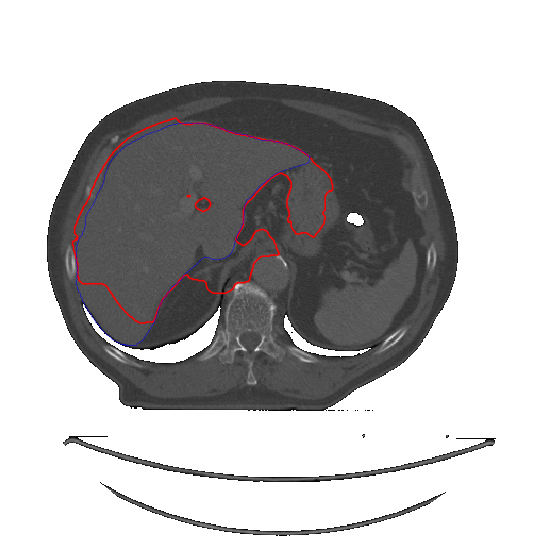

In [171]:
LUNG049=ct_and_mask("LUNG027CTScan.npy","LUNG027Segmentation.npy")
morph=LUNG049.morph_GAC()

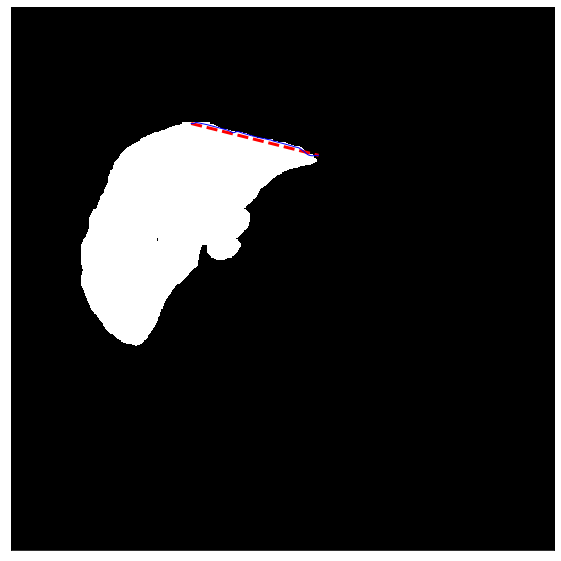

<Figure size 1080x1080 with 0 Axes>

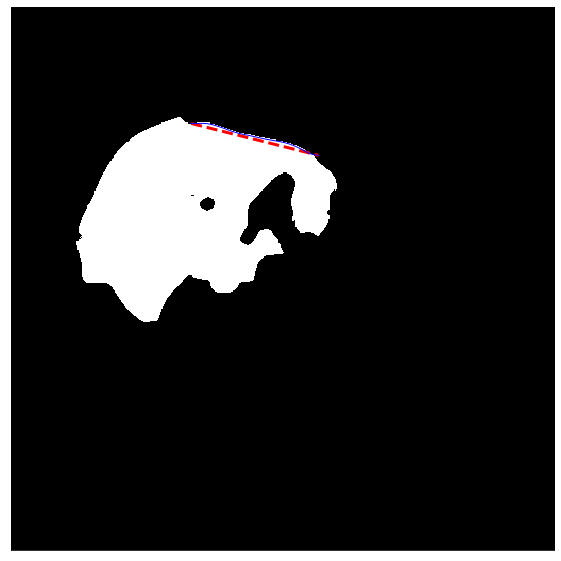

<Figure size 1080x1080 with 0 Axes>

[0.         0.21660551 0.43817581 1.08483427 1.0682046  1.03686931
 1.16752276 1.39200042 1.64716113 1.89556722 2.10604192 2.2528537
 2.32761902 2.33573585 2.30022443 2.24662878 2.19042832 2.12859019
 2.05970646 1.98385022 1.9008861  1.80578941 1.69499126 1.56820981
 1.42823308 1.28760474 1.16639063 1.10761621 1.17498128 1.40531529
 1.78288644 2.0465161  1.89168513 2.08536418 2.5649212  2.76138914
 2.88512832 2.96963989 2.99805306 2.95898053 2.85526532 2.71002851
 2.54875437 2.40512886 2.28783084 2.19710497 2.13336835 2.09970043
 2.09783938 2.12259405 2.17037699 2.23699199 2.30114179 2.35097655
 2.39633307 2.42103517 2.46258669 2.49413464 2.48888248 2.38658243
 2.29731152 2.26107926 2.30764875 2.39616224 2.48017028 2.54622846
 2.58715623 2.61303094 2.62459908 2.61170848 2.5795004  2.53846445
 2.4947766  2.44229197 2.37872381 2.29850671 2.17519399 1.99201904
 1.76323387 1.51346782 1.23825871 0.91580382 0.52917815 0.20127017
 0.26524138 0.35004176 0.35271662 0.84514812 0.93591304 1.21063

1.8457254359459376

In [176]:
snake=segment_measuring1(LUNG049.mask_file)
morph_measure=morph_measuring1(morph)



di=distance.cdist(morph_measure,snake , 'euclidean')
di2=np.diagonal(di)
print(di2)
np.mean(di2)

In [61]:
def morph_measuring2(image, x_start, y_start, x_end, y_end):
    img=image
    r = np.linspace(y_start, y_end, 100)
    c = np.linspace(x_start, x_end, 100)
    init = np.array([r, c]).T


    snake = active_contour(gaussian(img, 1), init, boundary_condition='fixed',
                           alpha=0.0015, beta=0.0001, w_line=0, w_edge=.1, gamma=0.0001,
                           coordinates='rc')

    fig, ax = plt.subplots(figsize=(10, 10))
    plt.figure(figsize=(15,15))
    ax.imshow(img, cmap=plt.cm.gray)
    ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
    ax.plot(snake[:, 1], snake[:, 0], '-b', lw=1)
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis([0, img.shape[1], img.shape[0], 0])
    plt.show()
    return snake

In [60]:
def segment_measuring2(image, x_start, y_start, x_end, y_end):
    img=image
    r = np.linspace(y_start, y_end, 100)
    c = np.linspace(x_start, x_end, 100)
    init = np.array([r, c]).T


    snake = active_contour(gaussian(img, 3), init, boundary_condition='fixed',
                           alpha=0.015, beta=1, gamma=0.001,
                           coordinates='rc')

                        
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.figure(figsize=(15,15))
    ax.imshow(img, cmap=plt.cm.gray)
    ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
    ax.plot(snake[:, 1], snake[:, 0], '-b', lw=1)
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis([0, img.shape[1], img.shape[0], 0])
    plt.show()
    return snake

/Users/gabrielbattcock/opt/anaconda3/lib/python3.7/site-packages/skimage/segmentation/morphsnakes.py:410: RuntimeWarning: invalid value encountered in greater
  threshold_mask_balloon = image > threshold / np.abs(balloon)
/Users/gabrielbattcock/opt/anaconda3/lib/python3.7/site-packages/skimage/segmentation/morphsnakes.py:431: RuntimeWarning: invalid value encountered in greater
  u[aux > 0] = 1
/Users/gabrielbattcock/opt/anaconda3/lib/python3.7/site-packages/skimage/segmentation/morphsnakes.py:432: RuntimeWarning: invalid value encountered in less
  u[aux < 0] = 0


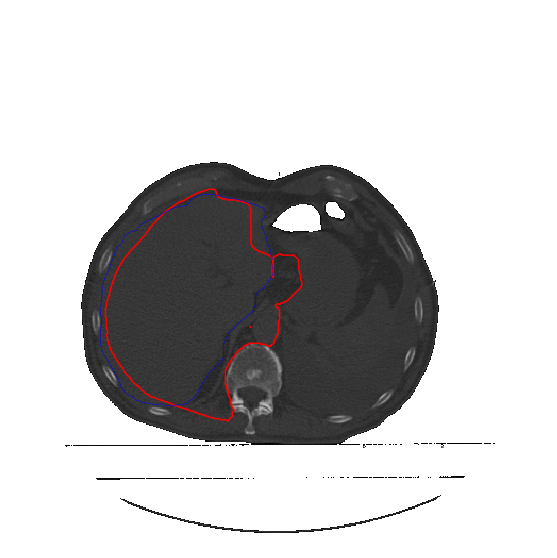

In [256]:
LUNG049=ct_and_mask("LUNG97CTScan.npy","LUNG97Segmentation.npy")
morph=LUNG049.morph_GAC()

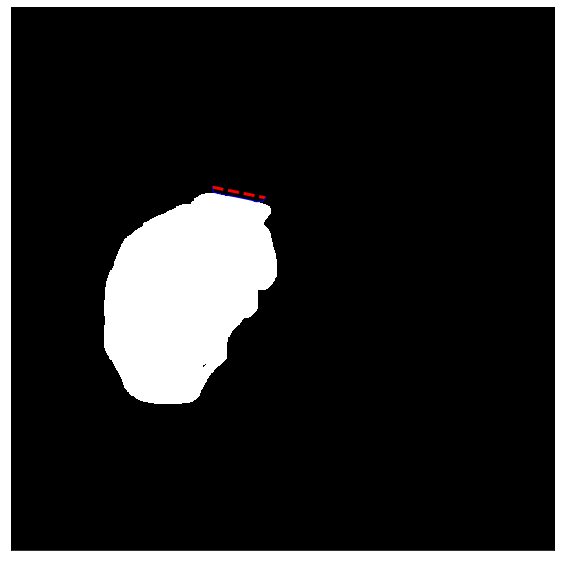

<Figure size 1080x1080 with 0 Axes>

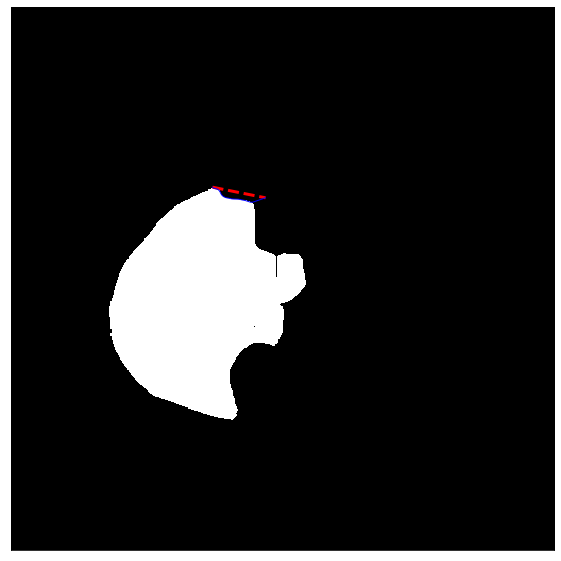

<Figure size 1080x1080 with 0 Axes>

[0.         0.43797798 1.72550763 3.17692619 3.43475725 3.50009343
 3.59109851 3.69589309 3.79950003 3.89015529 3.95718229 3.98890258
 3.9709195  3.8897848  3.74520079 3.53361308 3.26665292 2.95588173
 2.60847486 2.22885381 1.83280331 1.43701293 1.06155768 0.74504296
 0.57464584 0.64263891 0.8564494  1.1054854  1.34860856 1.57093033
 1.76741923 1.93957935 2.08777913 2.21071582 2.30827607 2.38135535
 2.43316694 2.46616832 2.4848111  2.49598705 2.5058588  2.52022441
 2.54272541 2.57162499 2.60240259 2.62914869 2.64534324 2.64489281
 2.62683404 2.59317315 2.54633081 2.48938395 2.42493414 2.35509858
 2.28159153 2.2059156  2.12957294 2.05417149 1.98169049 1.91446496
 1.85512086 1.80852438 1.77775478 1.75881898 1.74736133 1.73727974
 1.72134557 1.69854617 1.67169335 1.6451126  1.62451737 1.61636732
 1.62321429 1.64459873 1.6791626  1.72110108 1.76647011 1.81450735
 1.86425831 1.91418976 1.95702931 1.97605753 1.94181081 1.81822439
 1.58016326 1.24900603 0.92860809 0.83606368 1.07603065 1.4528

2.121635570862888

In [266]:
snake=segment_measuring2(LUNG049.mask_file, 190,170,240,180)
morph_measure=morph_measuring2(morph, 190,170,240,180)



di=distance.cdist(morph_measure,snake , 'euclidean')
di2=np.diagonal(di)
print(di2)
np.mean(di2)

/Users/gabrielbattcock/opt/anaconda3/lib/python3.7/site-packages/skimage/segmentation/morphsnakes.py:410: RuntimeWarning: invalid value encountered in greater
  threshold_mask_balloon = image > threshold / np.abs(balloon)
/Users/gabrielbattcock/opt/anaconda3/lib/python3.7/site-packages/skimage/segmentation/morphsnakes.py:431: RuntimeWarning: invalid value encountered in greater
  u[aux > 0] = 1
/Users/gabrielbattcock/opt/anaconda3/lib/python3.7/site-packages/skimage/segmentation/morphsnakes.py:432: RuntimeWarning: invalid value encountered in less
  u[aux < 0] = 0


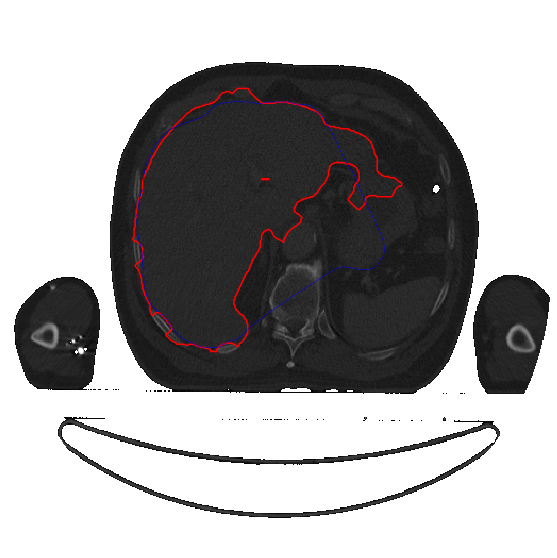

In [89]:
LUNG049=ct_and_mask("LUNG003CTScan.npy","LUNG003Segmentation.npy")
morph=LUNG049.morph_GAC()

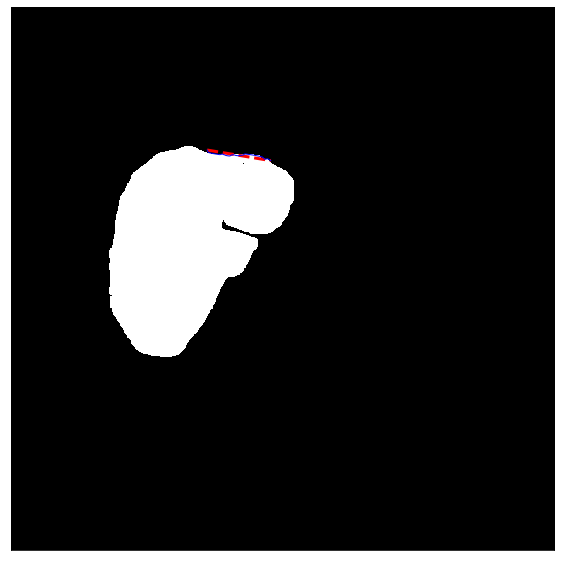

<Figure size 1080x1080 with 0 Axes>

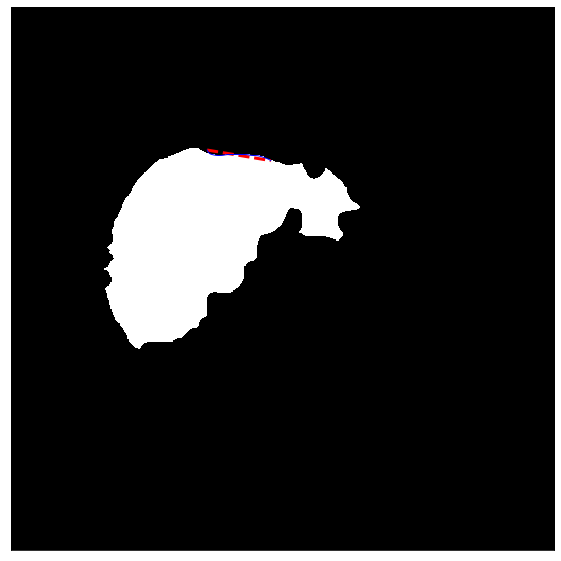

<Figure size 1080x1080 with 0 Axes>

[0.         0.37313018 0.18939057 0.26679255 0.64097737 1.07572046
 1.42459708 1.69787521 1.91703789 2.10182626 2.26253669 2.39759692
 2.50641934 2.58645745 2.63744711 2.65702236 2.64915552 2.62113032
 2.57880377 2.52610257 2.46520265 2.39687713 2.32072288 2.23859402
 2.18910516 2.21228641 2.14952495 2.08499049 1.9942376  1.79196255
 1.73309998 1.75272752 1.80085993 1.82509382 1.8371725  1.84591461
 1.84313042 1.76511116 1.47865593 1.08427722 0.84050501 0.70411886
 0.6158383  0.62998175 0.8421881  0.96025998 1.06275728 1.14210975
 1.17507544 1.13835339 1.06610558 0.99873841 1.0042576  1.07846331
 1.1647723  1.17696259 1.42193972 1.56322125 1.68374299 1.81093968
 1.93620177 2.05270838 2.15582394 2.24582858 2.32827823 2.40066598
 2.45987474 2.49999692 2.51738017 2.50634    2.45863479 2.37041132
 2.24896731 2.11094076 1.9753963  1.85585588 1.75426251 1.65918552
 1.54853345 1.39658415 1.19545521 0.97811934 0.76149991 0.55852498
 0.42158834 0.44315969 0.32371372 0.55310793 1.28976483 1.4061

1.4969055831405575

In [88]:
snake=segment_measuring2(LUNG049.mask_file, 185,135,245,145)
morph_measure=morph_measuring2(morph, 185, 135,245,145)



di=distance.cdist(morph_measure,snake , 'euclidean')
di2=np.diagonal(di)
print(di2)
np.mean(di2)


[1.172 1.554 1.936 2.318]


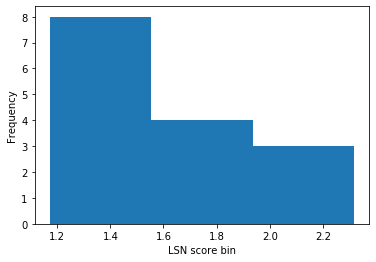

In [282]:
"""
data saved in an excel spreadsheet on mphys drive
"""

data=[1.742,1.272,1.358,1.576,1.918,1.196,1.286,1.172,1.998,1.356,1.59,1.394,1.332,2.318,2.082]
hist,bin_edges=np.histogram(data, bins=3)
print(bin_edges)
plt.hist(data, bins = 3)
plt.xlabel('LSN score bin')
plt.ylabel('Frequency')

plt.show()